In [1]:
## This notebook studied the available sky vs. time of day
## * simulate an input sky
## * simulate an instrument 
## * simulate a scanning strategy
## * simulate TOD from the 3 previous guys
## * project back your TOD to sky maps.

In [2]:
import sys
import os

## Include your path to the package
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../s4cmb')))

## Import modules and routines
from s4cmb.input_sky import HealpixFitsMap

from s4cmb.instrument import Hardware

from s4cmb.scanning_strategy import ScanningStrategy

from s4cmb.tod import TimeOrderedDataPairDiff
from s4cmb.tod import OutputSkyMap
from s4cmb.tod import partial2full

from cmb_footprint import footprint

## Other packages needed
import healpy as hp
import pylab as pl
import numpy as np
from IPython.display import Image

try:
    from tqdm import *
except ImportError:
    tqdm = lambda x: x

In [3]:
#################################################################
## START OF THE SIMULATION
## Flow is the following: 
##   sky -> instrument -> scanning strategy -> 
##   MAP2TOD -> (systematics) -> TOD2MAP
#################################################################

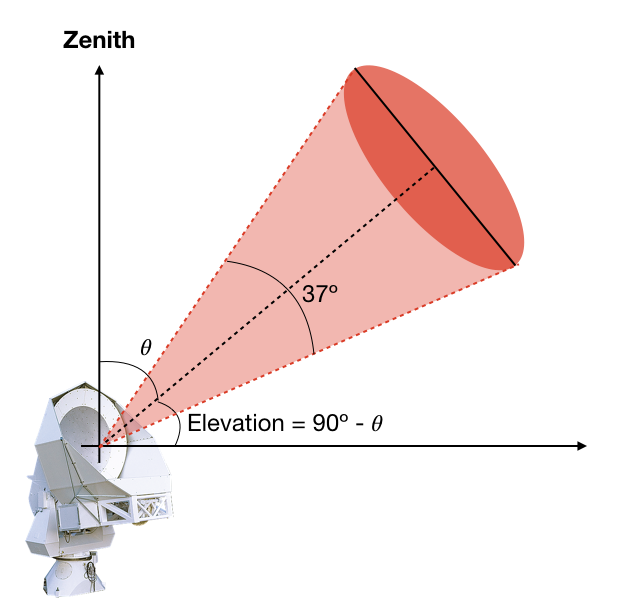

In [4]:
## Here we create a fake instrument located in Chile.

## Initialise our input maps to be scanned
## (for test purposes, we create the maps on-the-fly from a CAMB file)
## Note that HealpixFitsMap can take as input a fits file with sky maps already in.
nside_out = 256
sky_in = HealpixFitsMap('../s4cmb/s4cmb/data/test_data_set_lensedCls.dat', do_pol=True, 
                        fwhm_in=3.5, nside_in=nside_out, map_seed=5843787, verbose=False, 
                        no_ileak=False, no_quleak=False)

## Initialise our instrument
## Generate a focal plane with 4 Crate boards, each with 1 MUX board, 
## each with 1 Squid, each with 4 pairs of bolometers.
## The focal plane is 2m wide (37deg projected on the sky),
## and each detector beam is Gaussian with FWHM of 3.5 arcmin.
## We choose a pointing model with 5 parameters.
## Finally, we mount a continously rotating HWP @ 2Hz on the instrument.
inst = Hardware(ncrate=4, ndfmux_per_crate=1,
                nsquid_per_mux=1, npair_per_squid=4,
                fp_size=200., fwhm=3.5, 
                beam_seed=58347, projected_fp_size=37., pm_name='5params',
                type_hwp='CRHWP', freq_hwp=2., angle_hwp=0., verbose=False)

## Initialize our scanning strategy
## Our scanning strategy will consist in scanning the Southern sky from Chile.
## We will start the observation January, 1st 2013.
## We will set the sampling frequency of the detector to be 2 Hz, and we will 
## scan the sky at a speed of 1.0 deg/s.
NCES = 12
scan = ScanningStrategy(nces=NCES, start_date='2013/1/1 00:00:00',
                        telescope_longitude='-67:46.816',
                        telescope_latitude='-22:56.396', telescope_elevation=5200.,
                        name_strategy='deep_patch', sampling_freq=1.0, sky_speed=0.4,
                        ut1utc_fn='../s4cmb/s4cmb/data/ut1utc.ephem', language='fortran')
Image(filename='telescope_config.png')

In [5]:
## Sky fraction as a function of the elevation
def make_scan(sky_in, inst, scan, nside_out, el, az_min, az_max, bLST, eLST):
    """
    Simulate TOD according to the scan strategy 
    and project back the TOD to sky maps.
    """
    scan.nces = len(el)
    scan.elevation = el
    scan.az_min = az_min
    scan.az_max = az_max
    scan.begin_LST = bLST
    scan.end_LST = eLST
    scan.run()

    ## Let's now generate our TOD from our input sky, instrument, and scanning strategy
    ## This is where you want to parallelize for big runs, so that different processors 
    ## (or groups or procs) focus on different scans. Here is the serial version:
    ## Loop over scans
    for CESnumber in range(scan.nces):
        tod = TimeOrderedDataPairDiff(inst, scan, sky_in, CESnumber=CESnumber, 
                                      projection='healpix', nside_out=nside_out, width=360.)

        ## Initialise map containers
        if CESnumber == 0:
            sky_out_tot = OutputSkyMap(projection=tod.projection, 
                                       nside=nside_out, obspix=tod.obspix)

        ## Scan input map to get TODs
        d = np.array([
                tod.map2tod(det) for det in tqdm(range(inst.focal_plane.nbolometer))])

        ## Project TOD to maps
        tod.tod2map(d, sky_out_tot)
        
    return sky_out_tot

#################################################################
## Full az range @ elevation = 30 deg for 1 sideral day.
sky_out_tot_30deg = make_scan(sky_in, inst, scan, nside_out,
                              [30.], [0.], [360.], 
                              ['00:00:00.00'], ['23:59:59.00'])

#################################################################
## Full az range @ elevation = 40 deg for 1 sideral day.
sky_out_tot_40deg = make_scan(sky_in, inst, scan, nside_out,
                              [40.], [0.], [360.], 
                              ['00:00:00.00'], ['23:59:59.00'])
    
#################################################################
## Full az range @ elevation = 50 deg for 1 sideral day.
sky_out_tot_50deg = make_scan(sky_in, inst, scan, nside_out,
                              [50.], [0.], [360.], 
                              ['00:00:00.00'], ['23:59:59.00'])
    
#################################################################
## Full az range @ elevation = 60 deg for 1 sideral day.
sky_out_tot_60deg = make_scan(sky_in, inst, scan, nside_out,
                              [60.], [0.], [360.], 
                              ['00:00:00.00'], ['23:59:59.00'])
    

100%|██████████| 32/32 [00:02<00:00, 10.69it/s]


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/colorbar.py:871: RuntimeWarning: invalid value enco

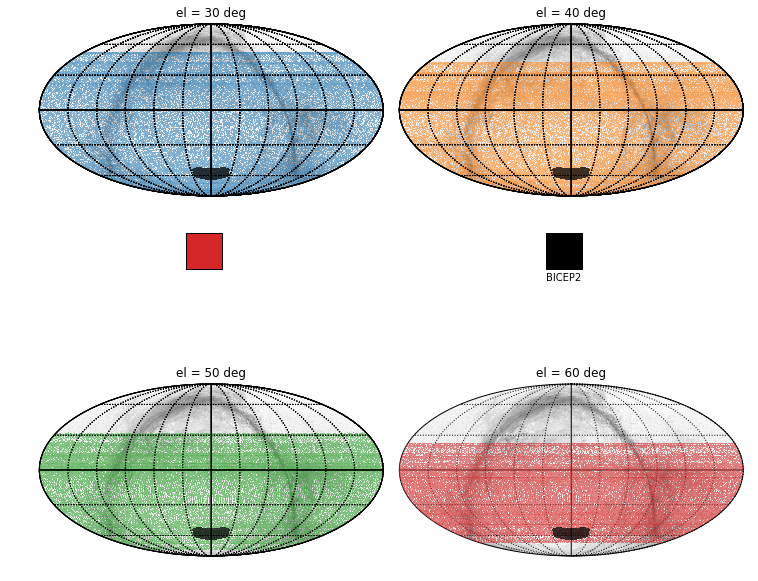

In [6]:
## Mollweide projection
nhit_30deg = partial2full(sky_out_tot_30deg.nhit, sky_out_tot_30deg.obspix, 
                          sky_out_tot_30deg.nside, fill_with=0.0)
nhit_40deg = partial2full(sky_out_tot_40deg.nhit, sky_out_tot_40deg.obspix, 
                          sky_out_tot_40deg.nside, fill_with=0.0)
nhit_50deg = partial2full(sky_out_tot_50deg.nhit, sky_out_tot_50deg.obspix, 
                          sky_out_tot_50deg.nside, fill_with=0.0)
nhit_60deg = partial2full(sky_out_tot_60deg.nhit, sky_out_tot_60deg.obspix, 
                          sky_out_tot_60deg.nside, fill_with=0.0)


fig = pl.figure(figsize=(10, 10))
fp = footprint.SurveyStack('PLANCK-DUSTPOL', title='el = 30 deg',
                           projection='mollweide', coord_plot='C', rot=[0,0],
                           config='/Users/julien/Documents/lib/cmb_footprint/footprint.cfg', fignum=1, sub=221) 
fp.superimpose_hpxmap(nhit_30deg, label='el = 30 deg', color='C0', coord_in='C')
fp.superimpose_survey('BICEP2-CONVEX', label='BICEP2', color='k')

fp = footprint.SurveyStack('PLANCK-DUSTPOL', title='el = 40 deg',
                           projection='mollweide', coord_plot='C', rot=[0,0],
                           config='/Users/julien/Documents/lib/cmb_footprint/footprint.cfg', fignum=1, sub=222) 
fp.superimpose_hpxmap(nhit_40deg, label='el = 40 deg', color='C1', coord_in='C')
fp.superimpose_survey('BICEP2-CONVEX', label='BICEP2', color='k')

fp = footprint.SurveyStack('PLANCK-DUSTPOL', title='el = 50 deg',
                           projection='mollweide', coord_plot='C', rot=[0,0],
                           config='/Users/julien/Documents/lib/cmb_footprint/footprint.cfg', fignum=1, sub=223) 
fp.superimpose_hpxmap(nhit_50deg, label='el = 50 deg', color='C2', coord_in='C')
fp.superimpose_survey('BICEP2-CONVEX', label='BICEP2', color='k')

fp = footprint.SurveyStack('PLANCK-DUSTPOL', title='el = 60 deg',
                           projection='mollweide', coord_plot='C', rot=[0,0],
                           config='/Users/julien/Documents/lib/cmb_footprint/footprint.cfg', fignum=1, sub=224) 
fp.superimpose_hpxmap(nhit_60deg, label='', color='C3', coord_in='C')
fp.superimpose_survey('BICEP2-CONVEX', label='BICEP2', color='k')

pl.show()

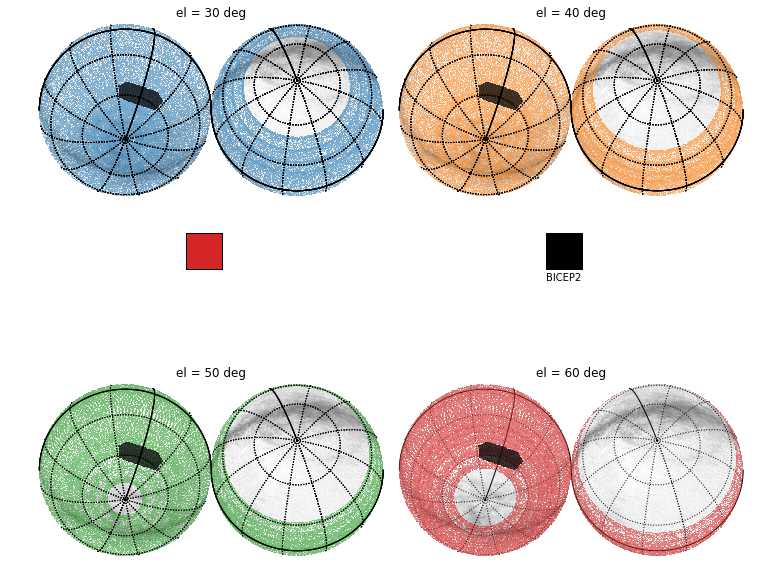

In [7]:
## Orthographic projection
nhit_30deg = partial2full(sky_out_tot_30deg.nhit, sky_out_tot_30deg.obspix, 
                          sky_out_tot_30deg.nside, fill_with=0.0)
nhit_40deg = partial2full(sky_out_tot_40deg.nhit, sky_out_tot_40deg.obspix, 
                          sky_out_tot_40deg.nside, fill_with=0.0)
nhit_50deg = partial2full(sky_out_tot_50deg.nhit, sky_out_tot_50deg.obspix, 
                          sky_out_tot_50deg.nside, fill_with=0.0)
nhit_60deg = partial2full(sky_out_tot_60deg.nhit, sky_out_tot_60deg.obspix, 
                          sky_out_tot_60deg.nside, fill_with=0.0)


fig = pl.figure(figsize=(10, 10))
fp = footprint.SurveyStack('PLANCK-DUSTPOL', title='el = 30 deg',
                           projection='orthographic', coord_plot='C', rot=[20,-70],
                           config='/Users/julien/Documents/lib/cmb_footprint/footprint.cfg', fignum=1, sub=221) 
fp.superimpose_hpxmap(nhit_30deg, label='el = 30 deg', color='C0', coord_in='C')
fp.superimpose_survey('BICEP2-CONVEX', label='BICEP2', color='k')

fp = footprint.SurveyStack('PLANCK-DUSTPOL', title='el = 40 deg',
                           projection='orthographic', coord_plot='C', rot=[20,-70],
                           config='/Users/julien/Documents/lib/cmb_footprint/footprint.cfg', fignum=1, sub=222) 
fp.superimpose_hpxmap(nhit_40deg, label='el = 40 deg', color='C1', coord_in='C')
fp.superimpose_survey('BICEP2-CONVEX', label='BICEP2', color='k')

fp = footprint.SurveyStack('PLANCK-DUSTPOL', title='el = 50 deg',
                           projection='orthographic', coord_plot='C', rot=[20,-70],
                           config='/Users/julien/Documents/lib/cmb_footprint/footprint.cfg', fignum=1, sub=223) 
fp.superimpose_hpxmap(nhit_50deg, label='el = 50 deg', color='C2', coord_in='C')
fp.superimpose_survey('BICEP2-CONVEX', label='BICEP2', color='k')

fp = footprint.SurveyStack('PLANCK-DUSTPOL', title='el = 60 deg',
                           projection='orthographic', coord_plot='C', rot=[20,-70],
                           config='/Users/julien/Documents/lib/cmb_footprint/footprint.cfg', fignum=1, sub=224) 
fp.superimpose_hpxmap(nhit_60deg, label='', color='C3', coord_in='C')
fp.superimpose_survey('BICEP2-CONVEX', label='BICEP2', color='k')

pl.show()

In [8]:
## Split day vs night

In [9]:
NCES = 1
scan = ScanningStrategy(nces=NCES, start_date='2013/1/1 00:00:00',
                        telescope_longitude='-67:46.816',
                        telescope_latitude='-22:56.396', telescope_elevation=5200.,
                        name_strategy='deep_patch', sampling_freq=1.0, sky_speed=0.4,
                        ut1utc_fn='../../s4cmb/s4cmb/data/ut1utc.ephem', language='fortran')
#################################################################
## Full az range @ elevation = 40 deg for 1/2 sideral day.
sky_out_tot_part1 = make_scan(sky_in, inst, scan, nside_out,
                              [50.], [0.], [360.], 
                              ['00:00:00.00'], ['11:59:59.00'])
    
#################################################################
## Full az range @ elevation = 40 deg for 1/2 sideral day.
sky_out_tot_part2 = make_scan(sky_in, inst, scan, nside_out,
                              [50.], [0.], [360.], 
                              ['12:00:00.00'], ['23:59:59.00'])
    

100%|██████████| 32/32 [00:01<00:00, 19.78it/s]


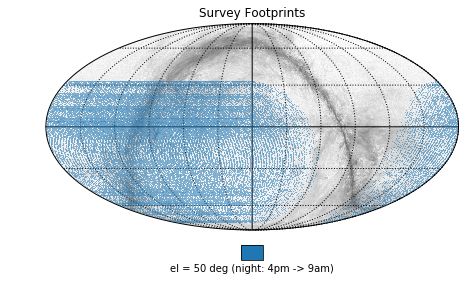

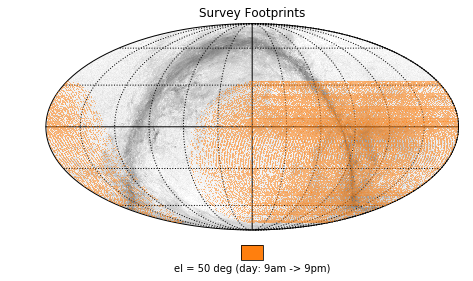

In [10]:
## PLot stuff
nhit_50deg_night = partial2full(sky_out_tot_part1.nhit, sky_out_tot_part1.obspix, 
                              sky_out_tot_part1.nside, fill_with=0.0)
nhit_50deg_day = partial2full(sky_out_tot_part2.nhit, sky_out_tot_part2.obspix, 
                                sky_out_tot_part2.nside, fill_with=0.0)

fp = footprint.SurveyStack('PLANCK-DUSTPOL',
                           projection='mollweide', coord_plot='C', rot=[0,0],
                           config='/Users/julien/Documents/lib/cmb_footprint/footprint.cfg') 
fp.superimpose_hpxmap(nhit_50deg_night, label='el = 50 deg (night: 4pm -> 9am)', color='C0', coord_in='C')
pl.show()
fp = footprint.SurveyStack('PLANCK-DUSTPOL',
                           projection='mollweide', coord_plot='C', rot=[0,0],
                           config='/Users/julien/Documents/lib/cmb_footprint/footprint.cfg') 
fp.superimpose_hpxmap(nhit_50deg_day, label='el = 50 deg (day: 9am -> 9pm)', color='C1', coord_in='C')
pl.show()